In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline


def calculate_psnr(image1, image2):
    """
    Calculate PSNR between two 2D images.
    
    Parameters:
    - image1: First 2D numpy array
    - image2: Second 2D numpy array
    
    Returns:
    - PSNR value
    """
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if there's no noise
    pixel_max = 255.0  # Assuming pixel values are in the range [0, 255]
    return 20 * np.log10(pixel_max / np.sqrt(mse))

def plotProfile(data, dirx, title="", compare_slice=None):
    """
    Plot a profile slice from a 3D numpy array and optionally compare with another 2D slice.
    
    Parameters:
    - data: 3D numpy array to be sliced and plotted
    - dirx: Slice direction (0, 1, 2, or -1)
    - title: Title of the plot
    - compare_slice: Optional 2D numpy array to compare with
    """
    
    # Validate the direction
    if dirx not in [0, 1, 2, -1]:
        raise ValueError("Slice direction 'dirx' should be [0, 1, 2, -1]")

    # Slice data based on direction
    if dirx == 0:
        loc = data.shape[0] // 2
        slice_data = data[loc, :, :]
        profile = slice_data[slice_data.shape[0] // 2, :]  # Profile across y-axis
    elif dirx == 1:
        loc = data.shape[1] // 2
        slice_data = data[:, loc, :]
        profile = slice_data[slice_data.shape[0] // 2, :]  # Profile across x-axis
    elif dirx == 2:
        loc = data.shape[2] // 2
        slice_data = data[:, :, loc]
        profile = slice_data[slice_data.shape[0] // 2, :]  # Profile across z-axis
    elif dirx == -1:  # When passing a 2D array
        slice_data = data
        profile = slice_data[slice_data.shape[0] // 2, :]

    # Calculate PSNR if compare_slice is provided
    psnr_value = None
    if compare_slice is not None:
        psnr_value = calculate_psnr(slice_data, compare_slice)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the slice
    ax[0].imshow(slice_data, cmap='gray')
    ax[0].axhline(slice_data.shape[0] // 2, linestyle='--', color='red')
    
    # Plot the profile
    ax[1].plot(profile)
    if psnr_value is not None:
        ax[1].set_title(f'Profile (PSNR: {psnr_value:.2f} dB)')
    else:
        ax[1].set_title('Profile')
    
    plt.suptitle(title)
    plt.show()

In [2]:
CleanCylinderPATH = "/lhome/ahmadfn/ICT2025/Paper/AluCube/CleanReco/volume.hdf5"
CleanCylinder = h5py.File(CleanCylinderPATH,'r')['Volume']
print("Shape of the volume: ",CleanCylinder.shape)

Shape of the volume:  (3162, 2400, 3162)


In [3]:
def add_Gaussian_noise(array, sigma):
    """
    Adds Gaussian noise to a 2D array.

    Parameters:
    - array: 2D numpy array
    - sigma: standard deviation of the Gaussian noise

    Returns:
    - noisy_array: 2D numpy array with added Gaussian noise
    """
    noise = np.random.normal(0, sigma, array.shape)
    noisy_array = array + noise
    return noisy_array


In [4]:
sliceClean = np.array(CleanCylinder[:,CleanCylinder.shape[1]//2,:])
print(sliceClean.shape)

(3162, 3162)


In [9]:
import sys
import os

sys.path.append("/lhome/ahmadfn/ICT2025/Paper/N2Ncopy/noise2noise")
from unet import UNet
from utils import *


# Now you can import your modules
from noise2noise.noise2noise import Noise2Noise
import torch
import torch.nn as nn
import math
from torch.optim import Adam, lr_scheduler
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Rest of your code
def save_volume_as_hdf5(volume, path):
    with h5py.File(path, 'w') as f:
        f.create_dataset('Volume', data=volume)

def create_patches_dual(image1, image2, patch_size=(32, 32)):
    """
    Create patches from two images.
    """
    patches1 = []
    patches2 = []
    img_h, img_w = image1.shape
    patch_h, patch_w = patch_size

    for i in range(0, img_h - patch_h + 1, patch_h):
        for j in range(0, img_w - patch_w + 1, patch_w):
            patch1 = image1[i:i + patch_h, j:j + patch_w]
            patch2 = image2[i:i + patch_h, j:j + patch_w]
            patches1.append(patch1)
            patches2.append(patch2)

    return np.array(patches1), np.array(patches2)



def find_closest_factors(N):
    for i in range(int(math.sqrt(N)), 0, -1):
        if N % i == 0:
            return (i, N // i)

def load_image(image):
    if isinstance(image, np.ndarray):
        if image.ndim == 2:
            img = np.stack([image], axis=-1)
        transform = transforms.ToTensor()
        img_tensor = transform(img).unsqueeze(0)
        return img, img_tensor
    else:
        raise TypeError("The input image should be a numpy array.")

class Args:
    def __init__(self, noise_type='Poisson'):
        #self.train_source_dir = 'data/train/source'
        #self.train_target_dir = 'data/train/target'
        #self.valid_source_dir = 'data/valid/source'
        #self.valid_target_dir = 'data/valid/target'
        self.ckpt_save_path = 'ckpts'
        self.ckpt_overwrite = True
        self.train_size = None
        self.valid_size = None
        self.learning_rate = 1e-3
        self.adam = [0.9, 0.99, 1e-08]
        self.batch_size = 8
        self.nb_epochs = 30
        self.loss = 'l1'
        self.cuda = torch.cuda.is_available()
        self.plot_stats = True
        self.noise_type = noise_type
        self.noise_param = 100
        self.seed = None
        self.crop_size = 32
        self.clean_targets = False
        self.no_crop = True
        self.add_noise = False

def train_and_denoise_slices(noisySliceA, noisySliceB, noisySliceTest, sliceClean, noise_type='Poisson'):
    params = Args(noise_type=noise_type)
    
    if params.cuda:
        torch.cuda.empty_cache()

    # Create patches from noisy slices
    patchesA, patchesB = create_patches_dual(noisySliceA, noisySliceB)

    # Split data into training and validation
    train_indices, val_indices = train_test_split(np.arange(patchesA.shape[0]), test_size=0.1, random_state=42)

    # Create in-memory datasets
    train_source_data = np.stack([patchesA[idx] for idx in train_indices])
    train_target_data = np.stack([patchesB[idx] for idx in train_indices])
    valid_source_data = np.stack([patchesA[idx] for idx in val_indices])
    valid_target_data = np.stack([patchesB[idx] for idx in val_indices])

    filesCount = len(train_indices)
    a, b = find_closest_factors(filesCount)
    b = filesCount // a

    params.batch_size = a
    params.report_interval = b

    # Convert data to float32 and create data loaders
    train_source_data = torch.tensor(train_source_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for grayscale
    train_target_data = torch.tensor(train_target_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for grayscale
    valid_source_data = torch.tensor(valid_source_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for grayscale
    valid_target_data = torch.tensor(valid_target_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for grayscale

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_source_data, train_target_data),
        batch_size=params.batch_size,
        shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(valid_source_data, valid_target_data),
        batch_size=params.batch_size,
        shuffle=False
    )

    # Initialize and train the Noise2Noise model
    n2n = Noise2Noise(params, trainable=True)
    n2n.train(train_loader, valid_loader)
    
    # Denoise the test slice
    _, img_tensor = load_image(noisySliceTest)
    img_tensor = img_tensor.to(dtype=torch.float32)  # Ensure dtype is float32
    if params.cuda:
        img_tensor = img_tensor.cuda()
    
    n2n.model.eval()
    with torch.no_grad():
        denoised_img_tensor = n2n.model(img_tensor).cpu().squeeze()
    
    # Since denoised_img_tensor is a 2D tensor, no need to permute dimensions
    denoised_img = denoised_img_tensor.numpy()

    psnr = calculate_psnr(denoised_img, sliceClean)
    return denoised_img, psnr


In [10]:
import pandas as pd

noise_types = ['Gaussian']
psnr_matrix = pd.DataFrame(index=noise_types, columns=noise_types)


def add_noise(slice, nt):
    noise_types = ['Gaussian']
    
    if nt in noise_types:
        # Determine the appropriate noise function and parameter based on noise type
        if nt in ['SaltnPepper', 'Speckle']:
            noise_param = 0.04
        else:
            noise_param = 4
        
        # Dynamically call the appropriate function
        noise_function = globals().get(f'add_{nt}_noise')
        if noise_function:
            noisy_slice = noise_function(slice, noise_param)
        else:
            raise ValueError(f"No noise function found for type: {nt}")
        
        return noisy_slice
    else:
        raise ValueError(f"Invalid noise type: {nt}")

for model_noise_type in noise_types:
    NoisyTrainA = add_noise(sliceClean, model_noise_type)
    NoisyTrainB = add_noise(sliceClean, model_noise_type)
    for test_noise_type in noise_types:
        # Create a noisy test slice for each noise type
        noisy_test_slice = add_noise(sliceClean, test_noise_type)
        # Load and denoise the noisy test slice using the model trained for each noise type
        print(f"Noise Model: {model_noise_type}, Noise Test: {test_noise_type}")
        denoised_img, psnr_denoised = train_and_denoise_slices(NoisyTrainA, NoisyTrainB, noisy_test_slice, sliceClean, model_noise_type)
        plotProfile(denoised_img, -1, "Denoised", noisy_test_slice)
        psnr_noisy = calculate_psnr(noisy_test_slice, sliceClean)
        psnr_matrix.at[test_noise_type, model_noise_type] = [psnr_noisy, psnr_denoised]

# Save results to CSV
psnr_matrix.to_csv('psnr_matrix.csv')



Noise Model: Gaussian, Noise Test: Gaussian
Noise2Noise: Learning Image Restoration without Clean Data (Lethinen et al., 2018)
Training parameters: 
  Train source dir = data/train/source
  Train target dir = data/train/target
  Valid source dir = data/valid/source
  Valid target dir = data/valid/target
  Ckpt save path = data/ckpts
  Ckpt overwrite = True
  Train size = None
  Valid size = None
  Learning rate = 0.001
  Adam = [0.9, 0.99, 1e-08]
  Batch size = 67
  Nb epochs = 30
  Loss = l1
  Cuda = True
  Plot stats = True
  Noise type = Gaussian
  Noise param = 100
  Seed = None
  Crop size = 32
  Clean targets = False
  No crop = True
  Add noise = False
  Report interval = 129

EPOCH 1 / 30
Batch   1 [=>                       ] Train loss: 0.00000

/zhome/ahmadfn/.pyenv/versions/3.9.7/envs/testN2N/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch 129 / 129 | Avg loss: 3.91687 | Avg train time / batch: 23 ms             
Train time: 0:00:03 | Valid time: 0:00:00 | Valid loss: 3.38678 | Avg PSNR: 35.56 dB
Saving checkpoint to: data/ckpts/Gaussian/n2n-Gaussian.pt

EPOCH 2 / 30
Batch 129 / 129 | Avg loss: 3.28629 | Avg train time / batch: 15 ms             
Train time: 0:00:02 | Valid time: 0:00:00 | Valid loss: 3.31315 | Avg PSNR: 35.76 dB
Saving checkpoint to: data/ckpts/Gaussian/n2n-Gaussian.pt

EPOCH 3 / 30
Batch 129 / 129 | Avg loss: 3.29401 | Avg train time / batch: 14 ms             
Train time: 0:00:02 | Valid time: 0:00:00 | Valid loss: 3.26717 | Avg PSNR: 35.88 dB
Saving checkpoint to: data/ckpts/Gaussian/n2n-Gaussian.pt

EPOCH 4 / 30
Batch 129 / 129 | Avg loss: 3.25410 | Avg train time / batch: 14 ms             
Train time: 0:00:02 | Valid time: 0:00:00 | Valid loss: 3.26228 | Avg PSNR: 35.90 dB
Saving checkpoint to: data/ckpts/Gaussian/n2n-Gaussian.pt

EPOCH 5 / 30
Batch 129 / 129 | Avg loss: 3.26059 | Avg train 

/tmp/ipykernel_3908209/2794714548.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


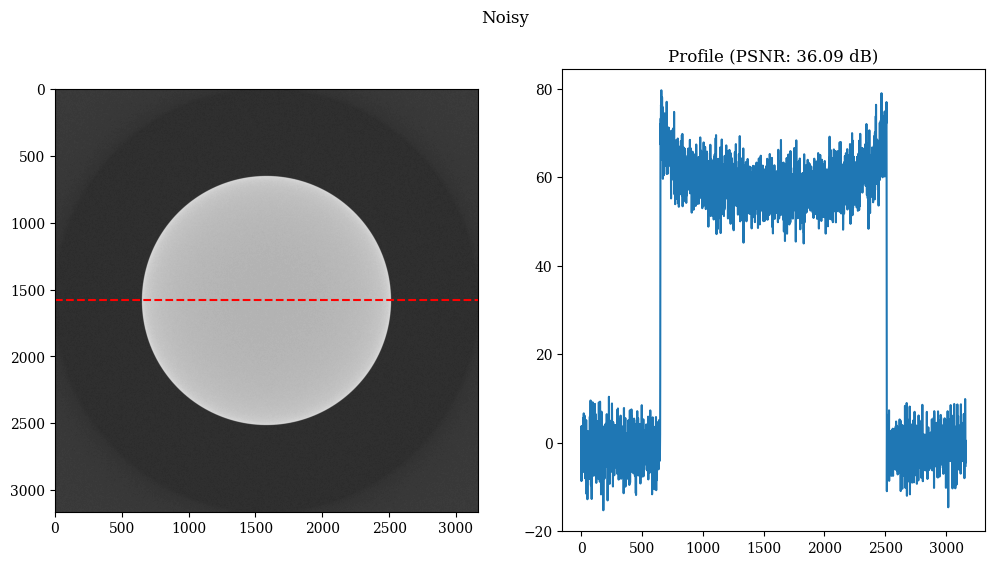

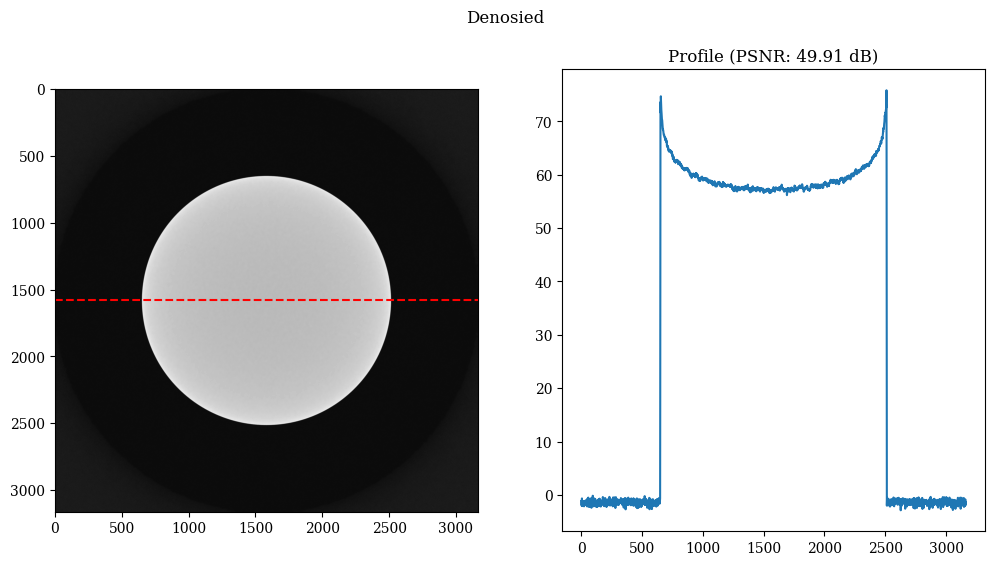

In [15]:
%matplotlib inline
plotProfile(noisy_test_slice,-1,"Noisy",sliceClean)
plotProfile(denoised_img,-1,"Denosied",sliceClean)